In [1]:
import os
from numpy import *
import pandas as pd

import matplotlib.pyplot as plt
# import seaborn as sns
import geopandas as gpd

# from rasterstats import zonal_stats
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import glob, os
# run for jupyter notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import rtree
from shapely.geometry import shape, mapping, Point, LinearRing

### Folder Structure

In [3]:
#%% Read in data
rice_root = '/home/apoorval/Research/GeoSpatial/India_Forests/'
dbox_root = '~/Dropbox/1_Research/India_Forests/'
# saad_root = '~/Dropbox/india_forests/'
# root = dbox_root 
# root = rice_root
root = dbox_root
code = root + 'Code'
data = root + 'Data'

In [ ]:
%pwd

In [3]:
path_proc = '/scratch/users/asimoes/data/processed/'
%cd {path_proc}
%ls

/scratch/users/asimoes/data/processed
all_village_deforestation_2011.gpkg
all_village_deforestation_centr_2011.geojson
all_village_deforestation.geojson
all_village_ex_ante_2011.gpkg
all_village_ex_ante_centr_2011.geojson
all_village_ex_ante.geojson
_all_villages_2011.gpkg
all_villages_2011.gpkg
all_villages_bloc_1991.cpg
all_villages_bloc_1991.dbf
all_villages_bloc_1991.shp
all_villages_bloc_1991.shx
all_villages_bloc_2001.cpg
all_villages_bloc_2001.dbf
all_villages_bloc_2001.geojson
all_villages_bloc_2001.shp
all_villages_bloc_2001.shx
all_villages_bloc_2011.cpg
all_villages_bloc_2011.dbf
all_villages_bloc_2011.prj
all_villages_bloc_2011.shp
all_villages_bloc_2011.shx
all_villages_bloc_shrid_2001.cpg
all_villages_bloc_shrid_2001.dbf
all_villages_bloc_shrid_2001.geojson
all_villages_bloc_shrid_2001.shp
all_villages_bloc_shrid_2001.shx
all_villages_centr_1991.geojson
all_villages_centr_2001.geojson
all_villages_centr_2011.geojson
all_villages_centr.geojson
_all_villages.geojson
defor_s

# Read Village level files 

In [4]:
vil_1 = gpd.read_file("all_village_deforestation_2011.gpkg")
vil_2 = gpd.read_file("all_village_ex_ante_2011.gpkg")

In [5]:
vil_1.shape
vil_2.shape

(615279, 155)

(615279, 140)

In [6]:
#Reading started at 5:25 - finished after 20min (5:47)

In [7]:
[x for x in vil_1.columns if x not in vil_2.columns]
ea_cols = [x for x in vil_2.columns if x not in vil_1.columns]

['deforest_0',
 'deforest_1',
 'deforest_3',
 'deforest_4',
 'deforest_5',
 'deforest_6',
 'deforest_7',
 'deforest_8',
 'deforest_9',
 'deforest_11',
 'deforest_12',
 'deforest_13',
 'deforest_14',
 'deforest_17',
 'deforest_count',
 'deforest_10',
 'deforest_2',
 'deforest_16',
 'deforest_15']

In [8]:
ea_cols

['preF_min', 'preF_max', 'preF_mean', 'preF_count']

### Regular merge on index  

In [9]:
vil = pd.merge(vil_1, vil_2.loc[:, ea_cols], right_index = True, left_index = True)

In [10]:
vil.columns

Index(['ANDAM_ID', 'ANDHR_ID', 'ARUNA_ID', 'ASSAM_ID', 'BIHAR_ID', 'CHAND_ID',
       'CHHAT_ID', 'CODE_2011', 'DADRA_ID', 'DAMAN_ID',
       ...
       'deforest_count', 'deforest_10', 'deforest_2', 'deforest_16',
       'deforest_15', 'geometry', 'preF_min', 'preF_max', 'preF_mean',
       'preF_count'],
      dtype='object', length=159)

In [ ]:
path_out = '/scratch/users/asimoes/data/processed/'
vil.to_file(path_out+'_all_villages_2011.gpkg', driver='GPKG')

# Create villages dataset with centroids and distance to relevant border

In [4]:
path_out = '/scratch/users/asimoes/data/processed/'
vil = gpd.read_file(path_out + '_all_villages_centr_2011.geojson')

In [12]:
border= gpd.read_file('/home/users/asimoes/data/processed/experiment_border.shp')

## Centroids 

In [13]:
from tqdm import tqdm

In [13]:
vil['centroid'] = vil.centroid
vil["x"] = vil.centroid.map(lambda p: p.x)
vil["y"] = vil.centroid.map(lambda p: p.y)
vil = vil.set_geometry('centroid')
vil.rename(columns={'geometry':'orig_geometry'},inplace=True)

In [16]:
vil.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 615279 entries, 0 to 615278
Columns: 158 entries, ANDAM_ID to centroid
dtypes: float64(137), geometry(1), int64(4), object(16)
memory usage: 741.7+ MB


## Nearest segment of border 

In [14]:
index = rtree.index.Index()
for ind, row in border.iterrows():
    geom1 = shape(row['geometry'])
    index.insert(ind, geom1.bounds)

In [15]:
nearest_segment     = lambda x: list(index.nearest(x.bounds, 1))[0]
# distance_to_nearest = lambda x: border.distance(x).min()

In [344]:
#USED THIS CELL ONLY TO FIND IDEAL STEP
#1.6 is the ideal step in the test sample
aux_bord['centroid'] = aux_bord.centroid
aux_bord['x'] = aux_bord.centroid.x
aux_bord['y'] = aux_bord.centroid.y
indxs = np.random.choice(vil.geometry.index, 100)
steps = np.arange(0.1,3,0.1)
start_time = time.time()
for step in steps:
    start_time = time.time()
    for indx in indxs:
        x = vil.geometry[indx].x
        y = vil.geometry[indx].y
        min_x = x-step
        max_x = x+step
        min_y = y-step
        max_y = y+step
        dist=np.nan
        while np.isnan(dist):
            dist = aux_bord[(aux_bord.x>=min_x)&(aux_bord.x<=max_x)&
            (aux_bord.y>=min_y)&(aux_bord.y<=max_x)].distance(vil.geometry[indx]).min()
            min_x -= step
            max_x += step
            min_y -= step
            max_y += step
    elapsed_time = time.time() - start_time
    print (step)
    print (elapsed_time)
    print ('\n')

0.1
5.378216981887817


0.2
2.7971553802490234


0.30000000000000004
1.9124362468719482


0.4
1.6051690578460693


0.5
1.3304996490478516


0.6
1.3336775302886963


0.7000000000000001
1.2436764240264893


0.8
1.173926830291748


0.9
1.1407155990600586


1.0
1.109518051147461


1.1
1.0000336170196533


1.2000000000000002
0.9845623970031738


1.3000000000000003
1.0291025638580322


1.4000000000000001
1.0532639026641846


1.5000000000000002
1.058457612991333


1.6
0.945533037185669


1.7000000000000002
0.9848957061767578


1.8000000000000003
1.0303561687469482


1.9000000000000001
1.030242919921875


2.0
1.1195733547210693


2.1
1.0887067317962646


2.2
1.139223575592041


2.3000000000000003
1.1312811374664307


2.4000000000000004
1.1220288276672363


2.5000000000000004
1.2455840110778809


2.6
1.2744882106781006


2.7
1.2905471324920654


2.8000000000000003
1.3271737098693848


2.9000000000000004
1.3483738899230957


CPU times: user 40.1 s, sys: 12.7 ms, total: 40.1 s
Wall time: 40.2 s


In [16]:
import numpy as np
border['centroid'] = border.centroid
border['x'] = border.centroid.x
border['y'] = border.centroid.y

def distance_to_nearest(geom):
    step=1.6
    x = geom.x
    y = geom.y
    min_x = x-step
    max_x = x+step
    min_y = y-step
    max_y = y+step
    dist=np.nan
    while np.isnan(dist):
        dist = border[(border.x>=min_x)&(border.x<=max_x)&
        (border.y>=min_y)&(border.y<=max_x)].distance(geom).min()
        min_x -= step
        max_x += step
        min_y -= step
        max_y += step
    return dist

In [17]:
%%time
vil['min_dist_to_border'] = vil.geometry.apply(distance_to_nearest)
print ('ok')

ok
CPU times: user 1h 38min 45s, sys: 27.7 s, total: 1h 39min 13s
Wall time: 1h 39min 14s


In [19]:
%%time
vil['nearest_segment'] = vil.geometry.apply(nearest_segment)

CPU times: user 1min 19s, sys: 408 ms, total: 1min 20s
Wall time: 1min 20s


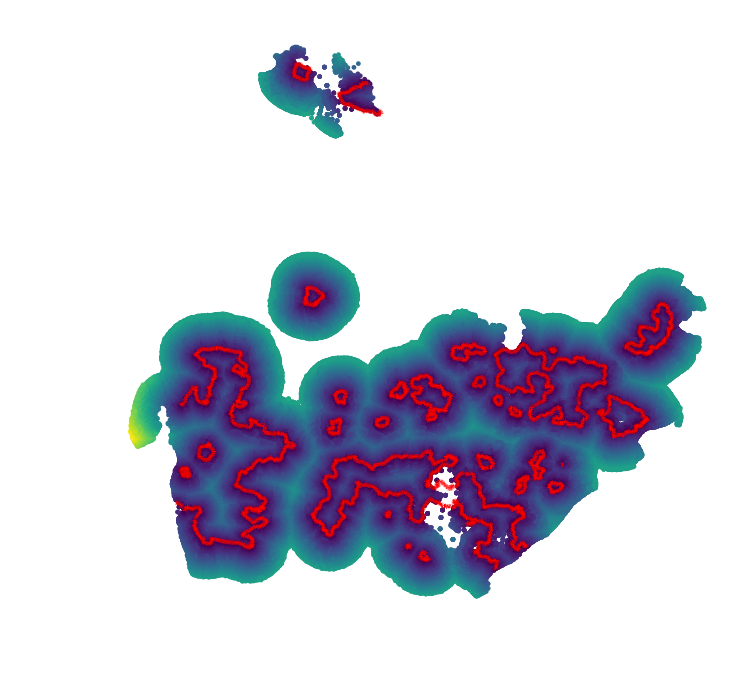

In [13]:
#%% plot minimum distance
f, ax = plt.subplots(1,dpi=200)
vil.plot(column='min_dist_to_border', cmap='viridis',
    markersize=0.5,ax=ax)
border.plot(edgecolor='red', ax=ax)
ax.set_axis_off()

In [20]:
vil.rename(columns = {'x': 'lon', 'y': 'lat'}, inplace = True)

## write csv for prelim analysis 

In [6]:
vil = gpd.read_file('vil_points.shp')

In [21]:
df = pd.DataFrame(vil)

In [22]:
path_csv = '/scratch/users/asimoes/data/intermediate/'
df.to_csv(path_csv + '19-11-29-villages_points_all_2011.csv')

In [23]:
vil.rename(columns={'orig_geometry':'geometry'},inplace=True)
vil = vil.set_geometry('geometry')
vil.drop(['centroid'], inplace = True, axis=1)

In [24]:
path_out = '/scratch/users/asimoes/data/processed/'
vil.to_file(path_out + 'vil_points_2011.gpkg', driver='GPKG')
print ('ok')

ok


In [27]:
vil.shape

(615279, 160)